In [25]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 加载 CSV 文件
data_dir = '../data/raw'  # 图像文件所在的目录
csv_file = '../data/dog_breeds_images.csv'  # CSV 文件路径
df = pd.read_csv(csv_file)

# 2. 加载和预处理图像
def load_images(dataframe):
    images = []
    labels = []
    for index, row in dataframe.iterrows():
        img_path = row['image']  # 使用CSV文件中的图像路径
        if not os.path.exists(img_path):
            print(f"File not found: {img_path}")
            continue
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(28, 28), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        images.append(img)
        labels.append(row['label'])
    return np.array(images), np.array(labels)

X, y = load_images(df)




/var/folders/l2/wcl7qkbj6tb3lmdhswqlh3jr0000gn/T/ipykernel_6647/654938573.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


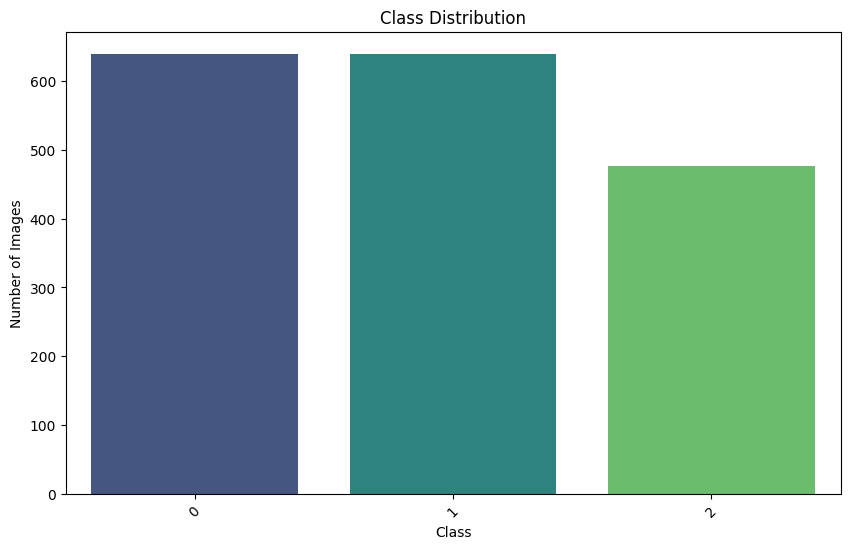

In [26]:
def plot_class_distribution(labels):
    # 计算每个类别的图像数量
    class_counts = pd.Series(labels).value_counts()

    # 绘制柱状图
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

# 可视化数据集类别分布
plot_class_distribution(y)


In [27]:
# 3. 标签进行 one-hot 编码
y = to_categorical(y)

# 4. 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. 定义模型架构
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))

# 6. 编译模型
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# 7. 训练模型
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))



Epoch 1/10


/Users/xinleichen/miniconda3/envs/myenv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4193 - loss: 1.0424 - val_accuracy: 0.6705 - val_loss: 0.7576
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6350 - loss: 0.7519 - val_accuracy: 0.6818 - val_loss: 0.6893
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6749 - loss: 0.6578 - val_accuracy: 0.6278 - val_loss: 0.6912
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7243 - loss: 0.6301 - val_accuracy: 0.7301 - val_loss: 0.5773
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7801 - loss: 0.5324 - val_accuracy: 0.7500 - val_loss: 0.5546
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8173 - loss: 0.4258 - val_accuracy: 0.8182 - val_loss: 0.4476
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8716 - loss: 0.3525 - val_accuracy: 0.8324 - val_loss: 0.3975
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9046 - loss: 0.2791 - val_accuracy: 0.8551 - val_loss: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.97      0.91       138
           1       0.99      0.81      0.89       124
           2       0.93      0.99      0.96        90

    accuracy                           0.92       352
   macro avg       0.93      0.92      0.92       352
weighted avg       0.92      0.92      0.92       352

Confusion Matrix:
 [[134   1   3]
 [ 20 100   4]
 [  1   0  89]]


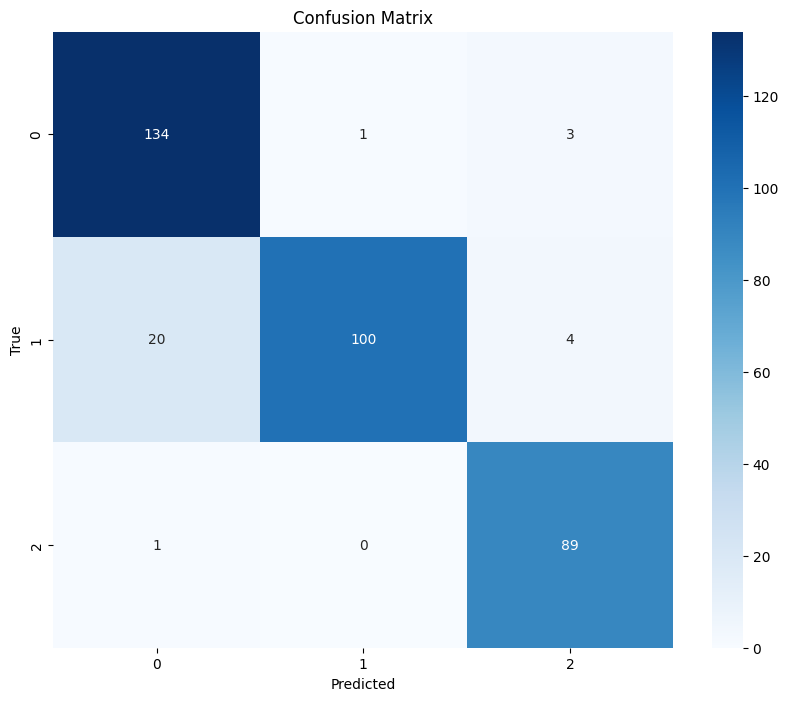

In [28]:
# 8. 评估模型
predictions = model.predict(X_val)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_val, axis=1)

# 计算分类报告和混淆矩阵
report = classification_report(y_true, y_pred)
matrix = confusion_matrix(y_true, y_pred)

# 输出分类报告和混淆矩阵
print("Classification Report:\n", report)
print("Confusion Matrix:\n", matrix)

# 绘制混淆矩阵
def plot_confusion_matrix(cm, class_labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

class_labels = list(df['label'].unique())
plot_confusion_matrix(matrix, class_labels)

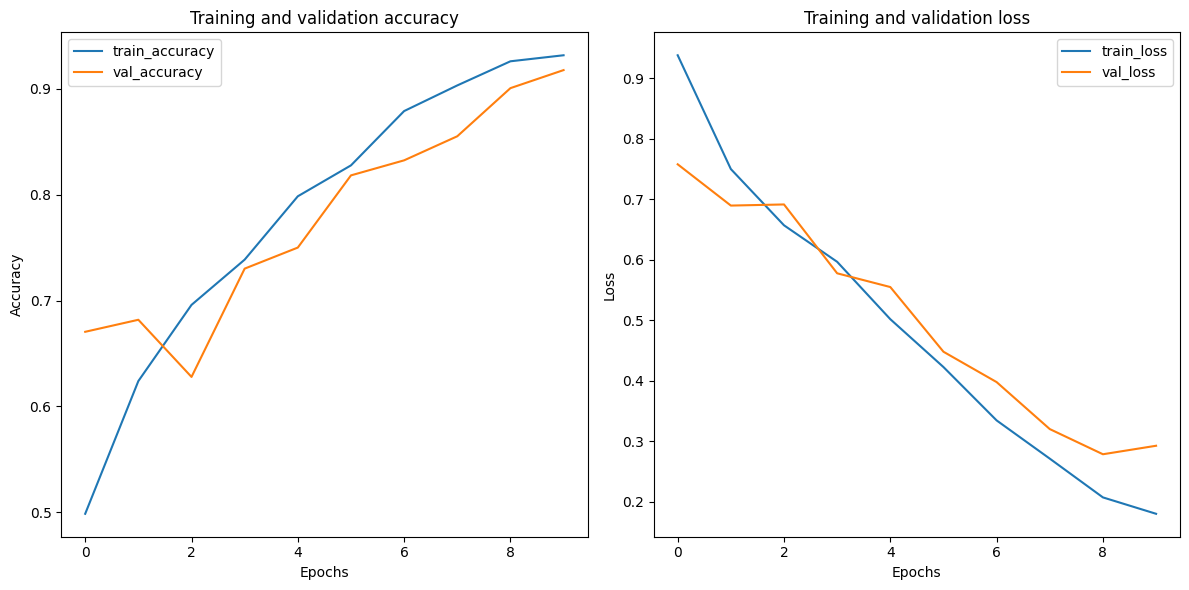

In [29]:

# 可视化训练过程
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)